In [1]:
import numpy as np
import keras
from keras.datasets import cifar10, cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import sys

/Users/pxenopoulos/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [146]:
''' Utilities for concept activation vectors '''
import numpy as np

from keras import backend as k
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

def return_split_models(model, layer):
    ''' Split a model into model_f and model_h

    Parameters
    ----------
    model : (keras.engine.sequential.Sequential)
        Keras sequential model to split
    layer : (int)
        Integer specifying layer to split model on

    Returns
    -------
    model_f : (keras.engine.sequential.Sequential)
        Keras sequential model that is the first part
    model_h : (keras.engine.sequential.Sequential)
        Keras sequential model that is the second part
    '''
    model_f, model_h = Sequential(), Sequential()
    for current_layer in range(0, layer+1):
        model_f.add(model.layers[current_layer])
    for current_layer in range(layer+1, len(model.layers)):
        model_h.add(model.layers[current_layer])
    return model_f, model_h

def train_cav(model_f, x_concept, y_concept):
    ''' Return the concept activation vector for the concept

    Parameters
    ----------
    model_f : (keras.engine.sequential.Sequential)
        First Keras sequential model from return_split_models()
    x_concept : (numpy.ndarray)
        Training data for concept set, has same size as model training data
    y_concept : (numpy.ndarray)
        Labels for concept set, has same size as model training labels

    Returns
    -------
    cav : (numpy.ndarray)
        Concept activation vector
    '''
    concept_activations = model_f.predict(x_concept)
    binary_classifier = Sequential()
    binary_classifier.add(Dense(1, input_shape=concept_activations.shape[1:], activation='sigmoid'))
    binary_classifier.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])
    binary_classifier.fit(concept_activations, y_concept, batch_size=32, epochs=20, shuffle=True)
    cav = binary_concept_classifier.layers[0].get_weights()[0]
    return cav

def conceptual_sensitivity(example, model_f, model_h, concept_cav):
    ''' Return the conceptual conceptual sensitivity for a given example

    Parameters
    ----------
    example : (numpy.ndarray)
        Example to calculate the concept sensitivity (be sure to reshape)
    model_f : (keras.engine.sequential.Sequential)
        First Keras sequential model from return_split_models()
    model_h : (keras.engine.sequential.Sequential)
        Second Keras sequential model from return_split_models()
    concept_cav : (numpy.ndarray)
        Numpy array with the linear concept activation vector for a given concept

    Returns
    -------
    sensitivity : (float32)
        Sensitivity for inputted examples
    '''
    model_f_activations = model_f.predict(example)[0]
    gradients = k.gradients(model_h.output, model_h.input)
    gradient_func = k.function([model_h.input], gradients)
    calc_grad = gradient_func([model_f_activations])[0]
    sensitivity = np.dot(calc_grad, concept_cav)
    return sensitivity

def tcav_score(x_train, y_train, model, layer, x_concept, y_concept):
    ''' Returns the TCAV score for the training data to a given concept

    Parameters
    ----------
    x_train : (numpy.ndarray)
        Training data where the i-th entry as x_train[i] is one example
    y_train : (numpy.ndarray)
        Training labels where the i-th entry as y_train[i] is one example
    model : (keras.engine.sequential.Sequential)
        Trained model to use
    layer : (int)
        Integer specifying layer to split model on
    x_concept : (numpy.ndarray)
        Training data for concept set, has same size as model training data
    y_concept : (numpy.ndarray)
        Labels for concept set, has same size as model training labels

    Returns
    -------
    tcav : (list)
        TCAV score for given concept and class
    '''
    model_f, model_h = return_split_models(model, layer)
    concept_cav = train_cav(model_f, x_concept, y_concept)
    unique_labels = np.unique(y_train)
    tcav = []
    for label in unique_labels:
        training_subset = x_train[np.array(y_train) == 1]
        set_size = training_subset.shape[0]
        count_of_sensitivity = 0
        for example in training_subset:
            sensitivity = conceptual_sensitivity(example, model_f, model_h, concept_cav)
            if sensitivity > 0:
                count_of_sensitivity = count_of_sensitivity + 1
        tcav.append(count_of_sensitivity/set_size)
    return tcav


In [147]:
# Set parameters
batch_size = 32
epochs = 5

In [148]:
# The data, split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Keep airplanes (0) and ships (8) from CIFAR-10
airplanes = y_train == [0]
ships = y_train == [8]
indices = airplanes + ships
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train = x_train[indx_to_use]
y_train = y_train[indx_to_use]

y_train = (y_train == 8).astype(int)
y_train = np.concatenate(y_train).ravel().tolist()

# Ships are now 1, airplanes are 0

# keep cloud (50) and sea (54) from CIFAR-100
(x_train_concept, y_train_concept), (x_test_concept, y_test_concept) = cifar100.load_data()

other = y_train_concept == [47]
concept = y_train_concept == [54]
indices = other + concept
indx_to_use = [i for i, x in enumerate(indices) if x]

x_train_concept = x_train_concept[indx_to_use]
y_train_concept = y_train_concept[indx_to_use]
y_train_concept = (y_train_concept == 54).astype(int)
y_train_concept = np.concatenate(y_train_concept).ravel().tolist()
# Sea is now 1, clouds are 0

In [149]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

# initiate optimizer
opt = keras.optimizers.Adam(lr=0.001)

# train the model
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=True)


Epoch 1/5
10000/10000 [==============================] - 31s 3ms/step - loss: 0.5924 - acc: 0.6816
Epoch 2/5
10000/10000 [==============================] - 30s 3ms/step - loss: 0.4671 - acc: 0.7839
Epoch 3/5
10000/10000 [==============================] - 30s 3ms/step - loss: 0.3589 - acc: 0.8471
Epoch 4/5
10000/10000 [==============================] - 30s 3ms/step - loss: 0.2997 - acc: 0.8739
Epoch 5/5
10000/10000 [==============================] - 30s 3ms/step - loss: 0.2535 - acc: 0.8961


In [150]:
model_f = Sequential()
model_f.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:], weights = model.layers[0].get_weights()))
model_f.add(Activation('relu'))
model_f.add(Conv2D(32, (3, 3), weights = model.layers[2].get_weights()))
model_f.add(Activation('relu'))
model_f.add(MaxPooling2D(pool_size=(2, 2)))
model_f.add(Dropout(0.25))

model_f.add(Conv2D(64, (3, 3), padding='same', weights = model.layers[6].get_weights()))
model_f.add(Activation('relu'))
model_f.add(Conv2D(64, (3, 3), weights = model.layers[8].get_weights()))
model_f.add(Activation('relu'))
model_f.add(MaxPooling2D(pool_size=(2, 2)))
model_f.add(Flatten())

acts = model_f.predict(x_train_concept)

model_h = Sequential()
model_h.add(Dense(512, input_shape=acts.shape[1:], weights = model.layers[13].get_weights()))
model_h.add(Activation('relu'))
model_h.add(Dropout(0.5))
model_h.add(Dense(1, weights = model.layers[16].get_weights()))
model_h.add(Activation('sigmoid'))

concept_cav = train_cav(model_f, x_train_concept, y_train_concept)

Epoch 1/20
1000/1000 [==============================] - 1s 632us/step - loss: 3.3513 - acc: 0.6440
Epoch 2/20
1000/1000 [==============================] - 0s 27us/step - loss: 1.5206 - acc: 0.8050
Epoch 3/20
1000/1000 [==============================] - 0s 37us/step - loss: 1.0026 - acc: 0.8550
Epoch 4/20
1000/1000 [==============================] - 0s 34us/step - loss: 0.7845 - acc: 0.8800
Epoch 5/20
1000/1000 [==============================] - 0s 39us/step - loss: 0.6226 - acc: 0.8990
Epoch 6/20
1000/1000 [==============================] - 0s 42us/step - loss: 0.4894 - acc: 0.9120
Epoch 7/20
1000/1000 [==============================] - 0s 36us/step - loss: 0.4206 - acc: 0.9340
Epoch 8/20
1000/1000 [==============================] - 0s 35us/step - loss: 0.3486 - acc: 0.9500
Epoch 9/20
1000/1000 [==============================] - 0s 46us/step - loss: 0.3038 - acc: 0.9470
Epoch 10/20
1000/1000 [==============================] - 0s 39us/step - loss: 0.2529 - acc: 0.9520
Epoch 11/20
1000/1

In [151]:
training_subset = x_train[np.array(y_train) == 1]

gradients = k.gradients(model_h.output, model_h.input)
gradient_func = k.function([model_h.input], gradients)
pos_sens = 0
list_sens = []
for train_ex in training_subset:
    example = train_ex.reshape((1, 32, 32, 3))
    example_f = model_f.predict(example)[0].reshape((1,2304))
    calc_grad = gradient_func([example_f])[0]
    sensitivity = np.dot(calc_grad, concept_cav)
    list_sens.append(sensitivity)
    if sensitivity > 0:
        pos_sens = pos_sens + 1


[array([[0.02478275]], dtype=float32), array([[0.00377371]], dtype=float32), array([[0.01880925]], dtype=float32), array([[0.0001231]], dtype=float32), array([[0.01611656]], dtype=float32), array([[0.00149332]], dtype=float32), array([[0.05548196]], dtype=float32), array([[0.00232387]], dtype=float32), array([[0.00318153]], dtype=float32), array([[0.00106951]], dtype=float32), array([[0.00770731]], dtype=float32), array([[0.00123302]], dtype=float32), array([[0.05556998]], dtype=float32), array([[0.00094499]], dtype=float32), array([[0.067707]], dtype=float32), array([[0.00055056]], dtype=float32), array([[0.00021642]], dtype=float32), array([[6.2461786e-06]], dtype=float32), array([[0.02922745]], dtype=float32), array([[0.02043685]], dtype=float32), array([[0.01453182]], dtype=float32), array([[0.00418063]], dtype=float32), array([[0.07266362]], dtype=float32), array([[0.00143959]], dtype=float32), array([[0.00016983]], dtype=float32), array([[0.01151764]], dtype=float32), array([[0.0

NameError: name 'plt' is not defined

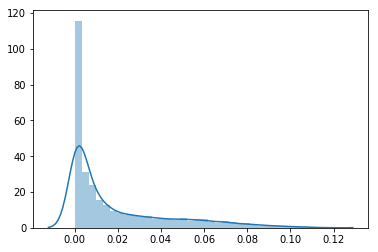

In [152]:
import seaborn as sns, numpy as np
ax = sns.distplot(list_sens)
plt.show()

In [166]:
training_subset = x_train[np.array(y_train) == 0]
i = 777
example = training_subset[i].reshape((1, 32, 32, 3))
example_f = model_f.predict(example)[0].reshape((1,2304))
gradients = k.gradients(model_h.output, model_h.input)
gradient_func = k.function([model_h.input], gradients)
calc_grad = gradient_func([example_f])[0]
sensitivity = np.dot(calc_grad, concept_cav)
sensitivity

array([[0.0078764]], dtype=float32)